In [8]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

In [23]:
dataset=pd.read_csv('btcusdt_1h_zelta.csv')

In [24]:
dataset=dataset.rename({'close':'Close','open':'Open','low':'Low','high':'High'},axis=1)
dataset.head(5)

,datetime,Open,High,Low,Close,volume
0,2018-01-01 05:30:00,13715.65,13715.65,13400.01,13529.01,443.356199
1,2018-01-01 06:30:00,13528.99,13595.89,13155.38,13203.06,383.697006
2,2018-01-01 07:30:00,13203.00,13418.43,13200.00,13330.18,429.064572
3,2018-01-01 08:30:00,13330.26,13611.27,13290.00,13410.03,420.087030
4,2018-01-01 09:30:00,13434.98,13623.29,13322.15,13601.01,340.807329


In [25]:
# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

In [26]:
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

In [27]:
dataset

,datetime,Open,High,Low,Close,volume,short_mavg,long_mavg,signal,EMA10,...,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200
0,2018-01-01 05:30:00,13715.65,13715.65,13400.01,13529.01,443.356199,13529.010000,13529.010000,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 06:30:00,13528.99,13595.89,13155.38,13203.06,383.697006,13366.035000,13366.035000,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 07:30:00,13203.00,13418.43,13200.00,13330.18,429.064572,13354.083333,13354.083333,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 08:30:00,13330.26,13611.27,13290.00,13410.03,420.087030,13368.070000,13368.070000,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 09:30:00,13434.98,13623.29,13322.15,13601.01,340.807329,13414.658000,13414.658000,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35203,2022-01-12 01:30:00,42972.04,43095.26,42692.19,42800.38,1219.601780,42248.181000,41878.675833,1.0,42423.405487,...,2013.81,65.108497,56.446745,47.488648,83.636890,85.935910,88.223086,91.504797,39.840203,40.329941
35204,2022-01-12 02:30:00,42797.62,42823.69,42643.74,42659.20,702.103800,42333.102000,41897.829000,1.0,42466.277217,...,1674.87,60.729494,55.200662,47.328413,75.926644,84.191939,82.612194,89.042195,38.054819,39.946699
35205,2022-01-12 03:30:00,42664.71,42776.14,42597.41,42713.13,561.859930,42423.146000,41915.636167,1.0,42511.159541,...,808.73,61.819414,55.588087,47.396555,78.871916,79.478483,84.739518,85.191600,38.736826,38.877283
35206,2022-01-12 04:30:00,42713.12,42886.28,42633.97,42729.29,681.142010,42525.923000,41930.164000,1.0,42550.819624,...,1544.84,62.168993,55.706825,47.417042,79.754461,78.184340,81.292768,82.881493,38.941188,38.577611


In [29]:
pd.set_option('display.max_columns', None)
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)
dataset.tail()

,datetime,Open,High,Low,Close,volume,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
35203,2022-01-12 01:30:00,42972.04,43095.26,42692.19,42800.38,1219.60178,42248.181,41878.675833,1.0,42423.405487,42079.267611,43220.939471,2.368788,4.431084,1169.36,2013.81,65.108497,56.446745,47.488648,83.636890,85.935910,88.223086,91.504797,39.840203,40.329941,42248.181,41954.187000,43286.9031
35204,2022-01-12 02:30:00,42797.62,42823.69,42643.74,42659.20,702.10380,42333.102,41897.829000,1.0,42466.277217,42116.682604,43215.350023,2.024529,1.801243,849.21,1674.87,60.729494,55.200662,47.328413,75.926644,84.191939,82.612194,89.042195,38.054819,39.946699,42333.102,42010.016000,43264.4316
35205,2022-01-12 03:30:00,42664.71,42776.14,42597.41,42713.13,561.85993,42423.146,41915.636167,1.0,42511.159541,42155.163081,43210.352809,2.425835,3.711789,900.44,808.73,61.819414,55.588087,47.396555,78.871916,79.478483,84.739518,85.191600,38.736826,38.877283,42423.146,42036.973667,43243.6246
35206,2022-01-12 04:30:00,42713.12,42886.28,42633.97,42729.29,681.14201,42525.923,41930.164000,1.0,42550.819624,42192.203528,43205.566114,2.611042,2.703332,1027.77,1544.84,62.168993,55.706825,47.417042,79.754461,78.184340,81.292768,82.881493,38.941188,38.577611,42525.923,42088.468333,43223.8038
35207,2022-01-12 05:30:00,42729.29,42965.00,42578.02,42675.00,1004.90689,42629.223,41945.631000,1.0,42573.397874,42223.351687,43200.286850,2.254928,3.336429,1033.00,1070.42,60.114442,55.193985,47.354772,74.386944,77.671107,78.104183,81.378823,38.254628,38.644214,42629.223,42124.149000,43204.7671


In [30]:
dataset.tail()

,datetime,Open,High,Low,Close,volume,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
35203,2022-01-12 01:30:00,42972.04,43095.26,42692.19,42800.38,1219.60178,42248.181,41878.675833,1.0,42423.405487,42079.267611,43220.939471,2.368788,4.431084,1169.36,2013.81,65.108497,56.446745,47.488648,83.636890,85.935910,88.223086,91.504797,39.840203,40.329941,42248.181,41954.187000,43286.9031
35204,2022-01-12 02:30:00,42797.62,42823.69,42643.74,42659.20,702.10380,42333.102,41897.829000,1.0,42466.277217,42116.682604,43215.350023,2.024529,1.801243,849.21,1674.87,60.729494,55.200662,47.328413,75.926644,84.191939,82.612194,89.042195,38.054819,39.946699,42333.102,42010.016000,43264.4316
35205,2022-01-12 03:30:00,42664.71,42776.14,42597.41,42713.13,561.85993,42423.146,41915.636167,1.0,42511.159541,42155.163081,43210.352809,2.425835,3.711789,900.44,808.73,61.819414,55.588087,47.396555,78.871916,79.478483,84.739518,85.191600,38.736826,38.877283,42423.146,42036.973667,43243.6246
35206,2022-01-12 04:30:00,42713.12,42886.28,42633.97,42729.29,681.14201,42525.923,41930.164000,1.0,42550.819624,42192.203528,43205.566114,2.611042,2.703332,1027.77,1544.84,62.168993,55.706825,47.417042,79.754461,78.184340,81.292768,82.881493,38.941188,38.577611,42525.923,42088.468333,43223.8038
35207,2022-01-12 05:30:00,42729.29,42965.00,42578.02,42675.00,1004.90689,42629.223,41945.631000,1.0,42573.397874,42223.351687,43200.286850,2.254928,3.336429,1033.00,1070.42,60.114442,55.193985,47.354772,74.386944,77.671107,78.104183,81.378823,38.254628,38.644214,42629.223,42124.149000,43204.7671


<Axes: title={'center': 'Correlation Matrix'}>

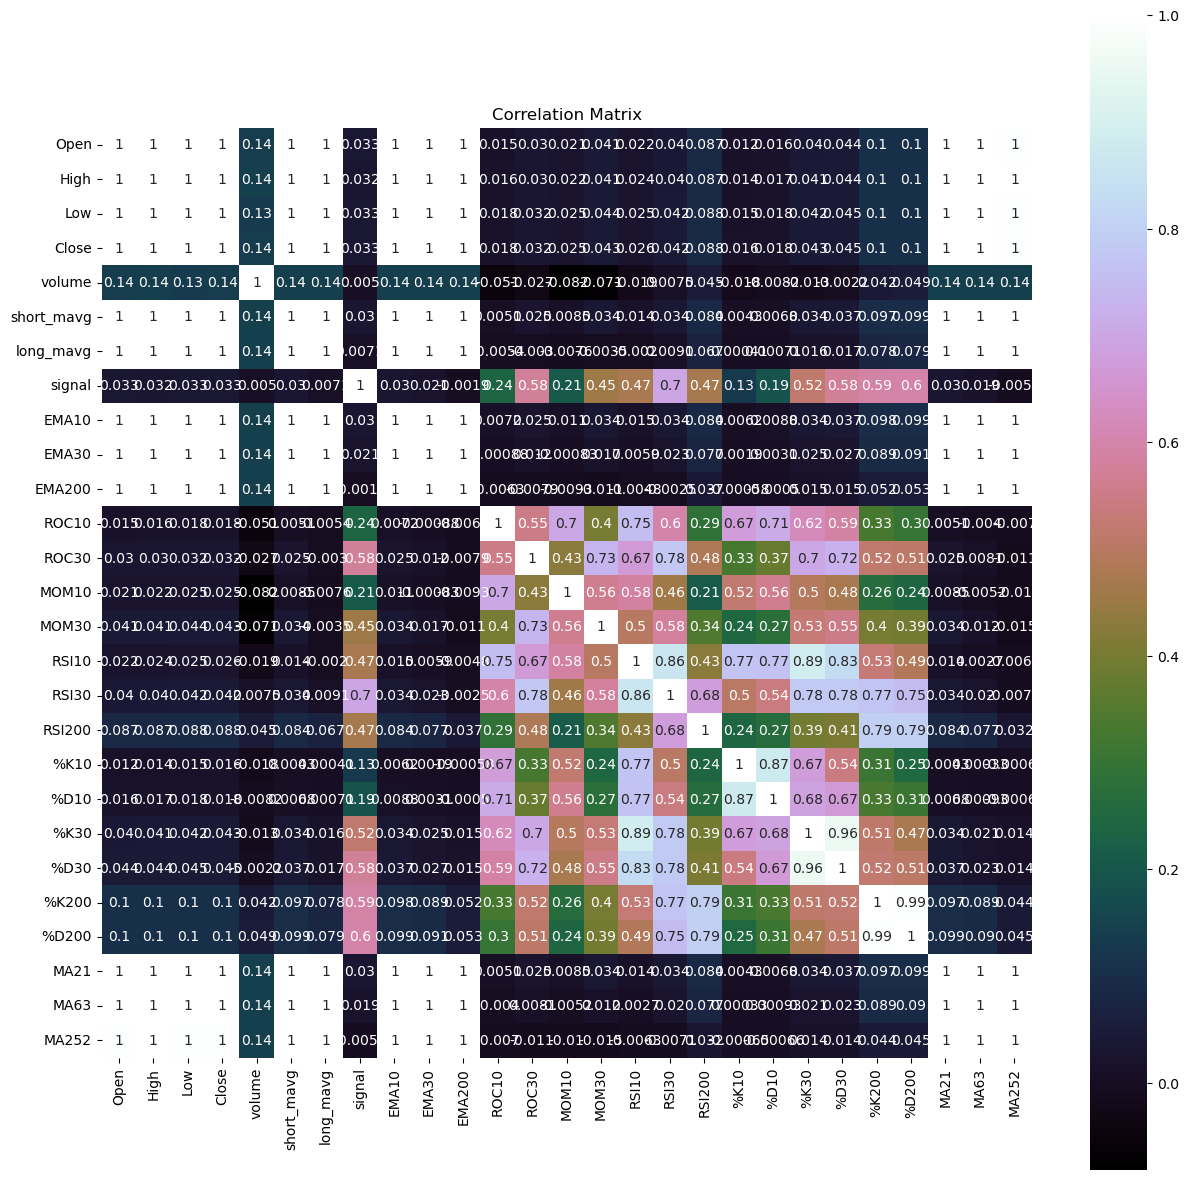

In [33]:
# correlation
dataset.set_index('datetime',inplace=True)
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')


In [68]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train=X[:28006]
X_validation=X[28006:]
Y_train=Y[:28006]
Y_validation=Y[28006:]
#X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

In [79]:

# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

In [80]:
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

In [81]:
dataset=dataset.dropna()

In [82]:
dataset

,Open,High,Low,Close,volume,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-09 15:30:00,14802.01,14816.10,14170.33,14500.00,1244.813107,15030.465,15695.089333,0.0,14923.220058,15138.169171,15448.510699,-4.857141,-8.045744,-745.89,-1141.01,38.559809,43.160962,51.432031,24.793370,40.072264,54.282113,64.144602,39.536943,47.079538,15030.465,15010.271667,15127.37800
2018-01-09 16:30:00,14500.00,14800.00,14382.00,14726.00,587.911186,14979.041,15656.026167,0.0,14887.361865,15111.577577,15440.234612,-3.222203,-6.544725,-514.24,-1042.71,44.282420,45.000140,51.757388,41.790068,29.980909,61.549741,60.038332,44.642857,43.581008,14979.041,14975.514667,15134.35710
2018-01-09 17:30:00,14726.00,14829.98,14401.00,14659.57,597.657793,14923.368,15616.867500,0.0,14845.945162,15082.415762,15431.305826,-3.618869,-7.598046,-556.73,-1097.70,42.975129,44.561692,51.655163,36.794092,34.459177,59.413509,58.415121,43.142035,42.440612,14923.368,14938.924667,15140.60480
2018-01-09 18:30:00,14650.00,14700.00,14011.05,14041.03,1156.790250,14806.471,15568.367667,0.0,14699.596951,15015.229506,15415.428275,-8.521532,-9.282428,-1168.97,-1823.97,32.920460,40.738422,50.717763,2.163137,26.915766,40.191042,53.718097,29.167646,38.984179,14806.471,14878.125667,15142.80490
2018-01-09 19:30:00,14072.87,14640.99,14064.13,14560.48,1087.916231,14727.619,15531.993333,0.0,14674.302960,14985.890797,15405.678731,-2.147312,-0.611058,-788.52,-917.26,44.940736,44.849203,51.461215,40.730198,26.562476,64.567208,54.723920,40.903340,37.737674,14727.619,14847.550333,15147.81235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-12 01:30:00,42972.04,43095.26,42692.19,42800.38,1219.601780,42248.181,41878.675833,1.0,42423.405487,42079.267611,43220.939471,2.368788,4.431084,1169.36,2013.81,65.108497,56.446745,47.488648,83.636890,85.935910,88.223086,91.504797,39.840203,40.329941,42248.181,41954.187000,43286.90310
2022-01-12 02:30:00,42797.62,42823.69,42643.74,42659.20,702.103800,42333.102,41897.829000,1.0,42466.277217,42116.682604,43215.350023,2.024529,1.801243,849.21,1674.87,60.729494,55.200662,47.328413,75.926644,84.191939,82.612194,89.042195,38.054819,39.946699,42333.102,42010.016000,43264.43160
2022-01-12 03:30:00,42664.71,42776.14,42597.41,42713.13,561.859930,42423.146,41915.636167,1.0,42511.159541,42155.163081,43210.352809,2.425835,3.711789,900.44,808.73,61.819414,55.588087,47.396555,78.871916,79.478483,84.739518,85.191600,38.736826,38.877283,42423.146,42036.973667,43243.62460


In [83]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.985289 (0.007221)
LDA: 0.897271 (0.017575)
CART: 0.879491 (0.015983)
NB: 0.783258 (0.045853)
NN: 0.810535 (0.112958)
AB: 0.901379 (0.014738)
GBM: 0.912769 (0.014071)
RF: 0.908449 (0.015287)


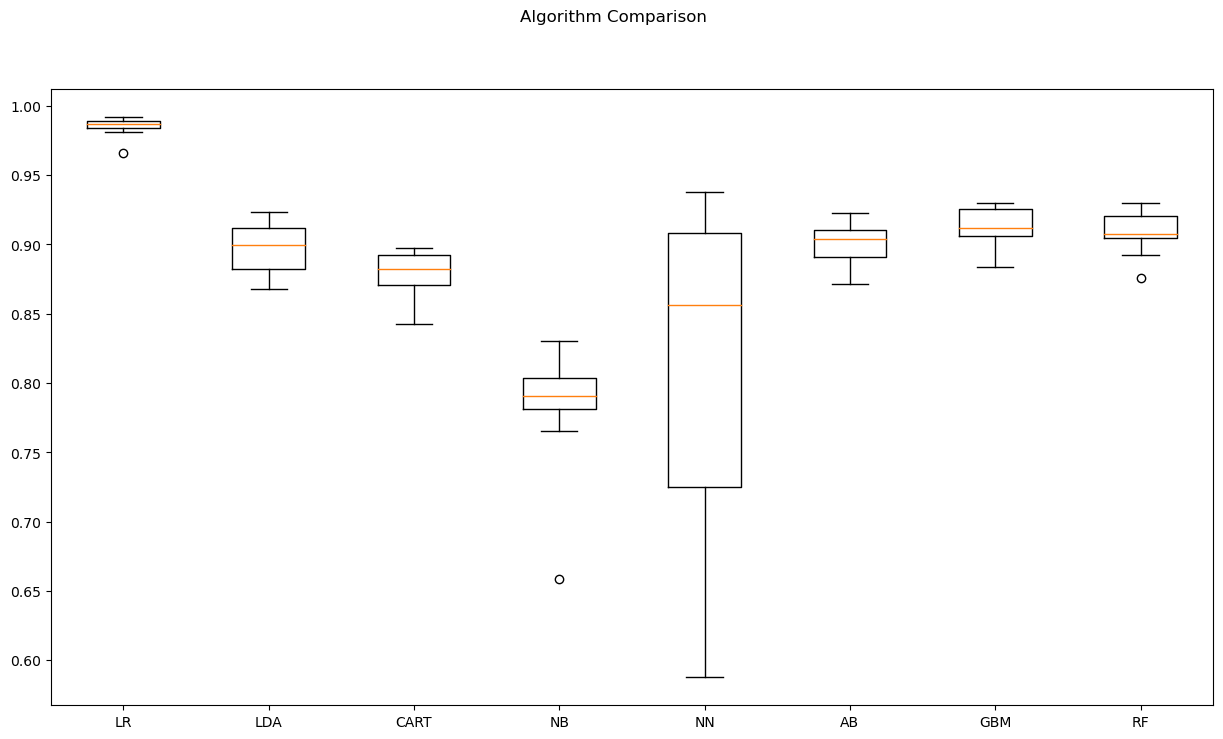

In [84]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

In [85]:
# Grid Search: Random Forest Classifier
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables    
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split. 
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
    
'''   
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.903879 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}
#8 0.877634 (0.015339) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#6 0.880740 (0.014351) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#4 0.898737 (0.018659) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#2 0.902093 (0.015755) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#7 0.879562 (0.015090) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#5 0.881205 (0.014811) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#3 0.901950 (0.016506) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#1 0.903879 (0.017617) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


In [86]:
# prepare model
model = RandomForestClassifier(criterion='entropy', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
#model = LogisticRegression() 
model.fit(X_train, Y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=80,
                       n_jobs=-1)

In [97]:
# estimate accuracy on validation set
predictions = model.predict(X)


Text(0.5, 0, 'Variable Importance')

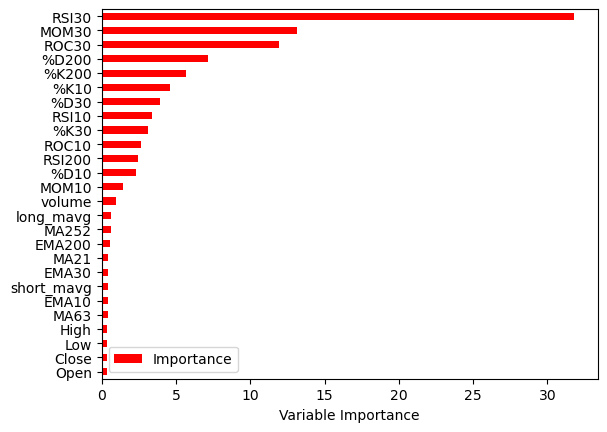

In [89]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

<Axes: >

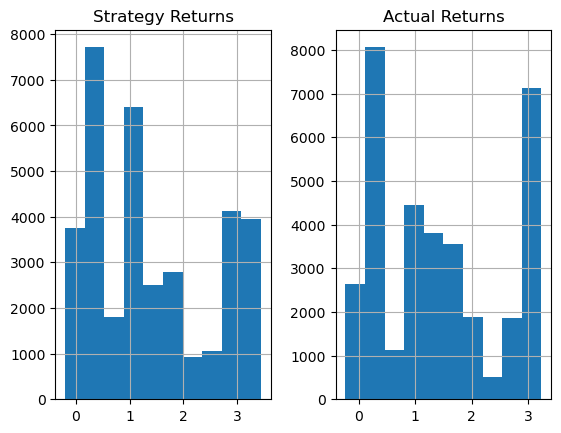

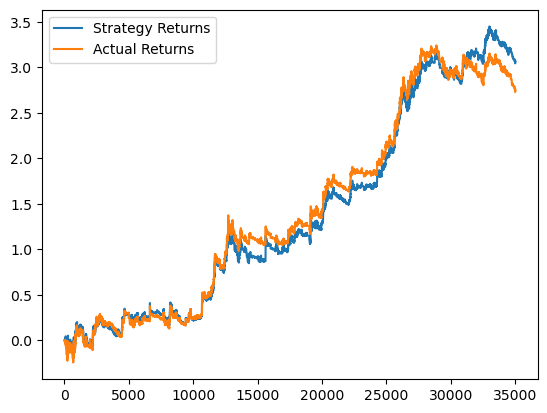

In [99]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X.index)
#backtestdata = pd.DataFrame()
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y
backtestdata['Market Returns'] = X['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()

In [100]:
X

,Open,High,Low,Close,volume,short_mavg,long_mavg,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-09 15:30:00,14802.01,14816.10,14170.33,14500.00,1244.813107,15030.465,15695.089333,14923.220058,15138.169171,15448.510699,-4.857141,-8.045744,-745.89,-1141.01,38.559809,43.160962,51.432031,24.793370,40.072264,54.282113,64.144602,39.536943,47.079538,15030.465,15010.271667,15127.37800
2018-01-09 16:30:00,14500.00,14800.00,14382.00,14726.00,587.911186,14979.041,15656.026167,14887.361865,15111.577577,15440.234612,-3.222203,-6.544725,-514.24,-1042.71,44.282420,45.000140,51.757388,41.790068,29.980909,61.549741,60.038332,44.642857,43.581008,14979.041,14975.514667,15134.35710
2018-01-09 17:30:00,14726.00,14829.98,14401.00,14659.57,597.657793,14923.368,15616.867500,14845.945162,15082.415762,15431.305826,-3.618869,-7.598046,-556.73,-1097.70,42.975129,44.561692,51.655163,36.794092,34.459177,59.413509,58.415121,43.142035,42.440612,14923.368,14938.924667,15140.60480
2018-01-09 18:30:00,14650.00,14700.00,14011.05,14041.03,1156.790250,14806.471,15568.367667,14699.596951,15015.229506,15415.428275,-8.521532,-9.282428,-1168.97,-1823.97,32.920460,40.738422,50.717763,2.163137,26.915766,40.191042,53.718097,29.167646,38.984179,14806.471,14878.125667,15142.80490
2018-01-09 19:30:00,14072.87,14640.99,14064.13,14560.48,1087.916231,14727.619,15531.993333,14674.302960,14985.890797,15405.678731,-2.147312,-0.611058,-788.52,-917.26,44.940736,44.849203,51.461215,40.730198,26.562476,64.567208,54.723920,40.903340,37.737674,14727.619,14847.550333,15147.81235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-12 01:30:00,42972.04,43095.26,42692.19,42800.38,1219.601780,42248.181,41878.675833,42423.405487,42079.267611,43220.939471,2.368788,4.431084,1169.36,2013.81,65.108497,56.446745,47.488648,83.636890,85.935910,88.223086,91.504797,39.840203,40.329941,42248.181,41954.187000,43286.90310
2022-01-12 02:30:00,42797.62,42823.69,42643.74,42659.20,702.103800,42333.102,41897.829000,42466.277217,42116.682604,43215.350023,2.024529,1.801243,849.21,1674.87,60.729494,55.200662,47.328413,75.926644,84.191939,82.612194,89.042195,38.054819,39.946699,42333.102,42010.016000,43264.43160
2022-01-12 03:30:00,42664.71,42776.14,42597.41,42713.13,561.859930,42423.146,41915.636167,42511.159541,42155.163081,43210.352809,2.425835,3.711789,900.44,808.73,61.819414,55.588087,47.396555,78.871916,79.478483,84.739518,85.191600,38.736826,38.877283,42423.146,42036.973667,43243.62460


<Axes: >

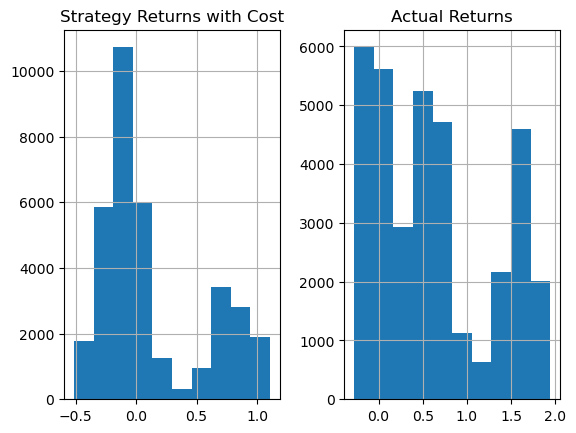

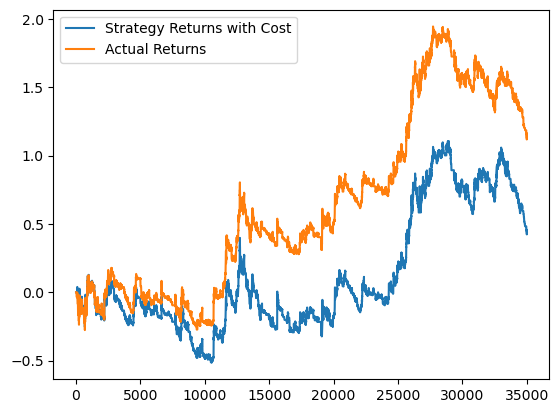

In [101]:
transaction_cost_pct = 0.002  # 0.2% transaction cost

# Calculate actual and strategy returns with transaction cost
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Actual Returns'] -= abs(backtestdata['signal_actual'].diff().shift(1)) * transaction_cost_pct

backtestdata['Strategy Returns with Cost'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata['Strategy Returns with Cost'] -= abs(backtestdata['signal_pred'].diff().shift(1)) * transaction_cost_pct

# Cumulative sum and plot
backtestdata[['Strategy Returns with Cost', 'Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns with Cost', 'Actual Returns']].cumsum().plot()


In [104]:
# Calculate the drawdown for strategy returns
backtestdata['Cumulative Strategy Returns'] = (1 + backtestdata['Strategy Returns with Cost']).cumprod()
backtestdata['Running Max Strategy Returns'] = backtestdata['Cumulative Strategy Returns'].cummax()
backtestdata['Drawdown Strategy'] = (backtestdata['Running Max Strategy Returns'] - backtestdata['Cumulative Strategy Returns'])

# Calculate the drawdown for actual returns
backtestdata['Cumulative Actual Returns'] = (1 + backtestdata['Actual Returns']).cumprod()
backtestdata['Running Max Actual Returns'] = backtestdata['Cumulative Actual Returns'].cummax()
backtestdata['Drawdown Actual'] = (backtestdata['Running Max Actual Returns'] - backtestdata['Cumulative Actual Returns'])

# Find the maximum drawdown for both strategy and actual returns
max_drawdown_strategy = backtestdata['Drawdown Strategy'].max()
max_drawdown_actual = backtestdata['Drawdown Actual'].max()

print(f"Maximum Drawdown (Strategy): {max_drawdown_strategy:.4%}")
print(f"Maximum Drawdown (Actual): {max_drawdown_actual:.4%}")


Maximum Drawdown (Strategy): 102.2056%
Maximum Drawdown (Actual): 271.1474%
